In [1]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

from typing import Tuple, Dict

import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from jaxley_mech.channels.l5pc import CaPump, CaHVA, CaLVA, NaTaT

import jaxley as jx
from jaxley import Compartment


In [2]:
class Compartment(Compartment):
    """
    Extend the Compartment class to include a voltage clamp method.
    """

    def voltage_clamp(
        self, 
        V_hold: float, 
        V_step: float, 
        V_post: float,
        T_hold: int, 
        T_step: int, 
        T_post: int,
        dt: float
    ) -> Tuple[
        Dict[str, Dict[str, jnp.ndarray]], Dict[str, Dict[str, Dict[str, jnp.ndarray]]]
    ]:
        """
        Apply a voltage clamp to the Compartment and record the resulting currents and state changes.

        Args:
            V_hold: The holding voltage in mV.
            V_step: The step voltage in mV.
            T_hold: The duration of the holding voltage in time steps.
            T_step: The duration of the step voltage in time steps.
            dt: The time step in ms.

        Returns:
            A tuple containing two dictionaries for the currents and state histories during the hold and step phases.
        """
        # Initialize the global state and dictionaries for currents and states
        states = {}
        channel_currents = {
            "hold": {channel._name: [] for channel in self.channels},
            "step": {channel._name: [] for channel in self.channels},
            "post": {channel._name: [] for channel in self.channels},
        }
        channel_states_history = {
            "hold": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
            "step": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
            "post": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },

        }

        for channel in self.channels:
            states.update(channel.channel_states)
        
        self.to_jax()
        params = self.get_all_parameters(self.show())
        # Function to update the states of all channels and record state history
        def update_all_channels(V, dt, phase):
            for channel in self.channels:
                current = channel.compute_current(
                    states, V, params
                )
                states[f"{channel._name}_current"] = current
                new_states = channel.update_states(
                    states, dt, V, params
                )
                states.update(new_states)
                # Record the state history for the current phase
                for state_key, state_value in new_states.items():
                    channel_states_history[phase][channel._name][state_key].append(
                        state_value
                    )

        # Function to compute and store the currents of all channels for the current phase
        def store_all_currents(V, phase):
            for channel in self.channels:
                current = channel.compute_current(states, V, params)
                channel_currents[phase][channel._name].append(current)

        # Hold at V_hold for T_hold duration
        for _ in range(T_hold):
            update_all_channels(V_hold, dt, "hold")
            store_all_currents(V_hold, "hold")

        # Step to V_step and record currents for T_step duration
        for _ in range(T_step):
            update_all_channels(V_step, dt, "step")
            store_all_currents(V_step, "step")

        for _ in range(T_step):
            update_all_channels(V_step, dt, "post")
            store_all_currents(V_step, "post")

        # Convert the lists in channel_currents and channel_states_history to jnp.ndarray
        for phase in ("hold", "step", "post"):
            for channel_name in channel_currents[phase]:
                channel_currents[phase][channel_name] = jnp.array(
                    channel_currents[phase][channel_name]
                )
                for state_name in channel_states_history[phase][channel_name]:
                    channel_states_history[phase][channel_name][state_name] = jnp.array(
                        channel_states_history[phase][channel_name][state_name]
                    )

        return channel_currents, channel_states_history

In [3]:
# params = {


#     # Ca dynamics
#     "CaCon_i": 0.0001,

# }

cell = Compartment()

cell.insert(NaTaT())
cell.insert(CaHVA())
cell.insert(CaLVA())
cell.insert(CaPump())

# for param in params:
#     cell.set(param, params[param])


In [4]:
cell.channels[1].channel_states

{'CaHVA_m': 0.1, 'CaHVA_h': 0.1}

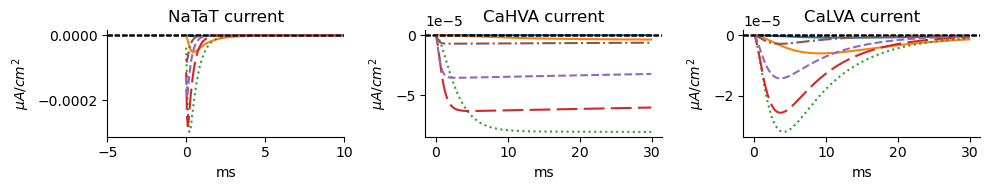

In [6]:
V_hold = -80  # mV, the holding potential
T_hold = 600    # ms, the duration of the holding potential
T_step = 600    # ms, the duration of the step potential
T_post = 600    # ms, the duration of the post potential
dt = 0.05       # ms, the time step for the simulation

fig, ax = plt.subplots(1, 3, figsize=(10,2))
ax = ax.flatten()

linestyles = {
    "-50": "solid",
	"-40": "solid",
	"-20": "dotted",
	"0": (5, (10, 3)),
	"20": "dashed",
	"40": "dashdot",
}

for V_step in [-50, -40, -20, 0, 20, 40]:
    currents, states = cell.voltage_clamp(
        V_hold=V_hold, 
        V_step=V_step,
        V_post=V_hold,
        T_hold=T_hold, 
        T_step=T_step, 
        T_post=T_hold,
        dt=dt)

    ax = ax.flatten()
    for i, key in enumerate(currents["step"]):
        if key == "CaPump":
            continue
        if "Na" in key:
            ax[i].set_xlim(-5, 10)
        ax[i].plot(jnp.arange(T_step) * dt, currents['step'][key], label=f"V={V_step}", linestyle=linestyles[str((V_step))])
        ax[i].set_title(key + " current")
        ax[i].set_xlabel("ms")
        ax[i].set_ylabel(r"$μA/cm^2$")
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].axhline(0, color="black", lw=1, ls="--")
    
fig.tight_layout()